In [1]:

import RNA
# Code folding for jupyter
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')




In [141]:
%matplotlib inline
E.enable_nbextension('usability/codefolding/main')

%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *


import RNA
import numpy as np 
from altschulEriksonDinuclShuffle import dinuclShuffle
import random
# def get_subsequence_prob(rna_seq):


from matplotlib import pyplot as plt
import mpld3 
from mpld3 import plugins
# mpld3.enable_notebook()
import pandas as pd

def plot_scatter(x, y, xlab, ylab, labels, fig, ax, color=None, scale='linear'):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    y = [yy + 1e-5 for yy in y ]
    if color is not None:
        cc = color
    else:
        cc = 'skyblue'
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_yscale(scale)
    ax.set_xlim([1,400])
    if scale =='log':
       ax.set_yscale(scale)
       ax.set_ylim([1e-6, 20])
    if scale =='linear':
       ax.set_yscale(scale)
       ax.set_ylim([-0.05,1.3])
    
    points = ax.scatter(x, y, s=10, linewidth='0', c=cc)
    legend = ax.legend(loc='upper right', shadow=False)

    # Connect d3 points with mouse over lables
    tooltip = plugins.PointLabelTooltip(points, labels)
    plugins.connect(fig, tooltip)

def plot_scatter_df(mydf, pdfname='defaultname', scale='linear', what='both', plot_mfe=False, plot_quake=False):
    
    if what == 'both':
        fig = plt.figure(figsize=(10, 10))
        subplot_num = 210
    else:
        fig = plt.figure(figsize=(10, 5))
        subplot_num = 110
    
    mpld3.plugins.clear(fig)  # clear all plugins from the figure    
    suffix = ""
    if plot_mfe:
        suffix += "-mfe"
    else:
        suffix += "-prob"
    
    if plot_quake:
        suffix += "-quake"
        
    # if scale == 'linear':
    #    ax.set_ylim([min(-20,  min(mydf[nameY])),max(30, max(mydf[nameY]))])
    # import math
    #     yrange = round(mydf[nameY].median()/10) * 10
    #     print "{} median: {}".format(nameY, mydf[nameY].median())
    #     ax.set_ylim([yrange-100, yrange+100])#[mydf[nameY].median() - 10 ,mydf[nameY].median() + 10])
    if what == 'both' or what=='split':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['split'+suffix], 'context-length', suffix, 
                 [str(v) for v in list(mydf.index.values)], fig, ax, 
                 color='y', scale=scale)
    if what == 'both' or what=='extend':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['extend'+suffix], 'context-length', suffix,
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color='b', scale=scale)
    if plot_quake:
        pdfname += "-quake"
    fig.suptitle(pdfname+"-"+what, y =0.96)
    fig.savefig (pdfname+"-"+what+".svg", dpi=600) #, bbox_inches='tight')

def my_eval(rna_seq, context, l_pos, r_pos, rna_split_pos, step=10, quake_opts=[False], use_pywrapper=True):
    context = context.upper()
    cont_lengths, inner_probs, outer_probs, inner_mfes, outer_mfes = [] , [], [], [], []
    inner_probs_quake, outer_probs_quake, inner_mfes_quake, outer_mfes_quake = [] , [], [], []
#     assert not (use_quake and use_pywrapper)
    for context_len in range(0,400,step):
        # select a range of the context, each time reshuffle to not stick into a (rare) sub-minimal case
        selection = dinuclShuffle(context)[0:context_len]
        # Insert the rna inbetween selection, insert position is from a normal distribution with mean 
        # be the center of the selected context
        center_pos = len(selection)/2
        insert_pos = max(0, int(np.random.normal(center_pos, 1+center_pos*0.1 )))
        print "(", context_len, center_pos, insert_pos, ")", 
        full_seq_inner = selection[:insert_pos] +  rna_seq + selection[insert_pos:]
        full_seq_outer = rna_seq[:rna_split_pos] +  selection + rna_seq[rna_split_pos:]
#         print full_seq_outer
    #     print full_seq[insert_pos:insert_pos+len(histone)]
    #     print full_seq[insert_pos+l_pos], full_seq[insert_pos+r_pos]
        if use_pywrapper:
            structure = ""
            RNA.pf_fold(full_seq_inner, structure)
            inner_prob = RNA.get_pr(insert_pos+l_pos+1,insert_pos+r_pos+1)

            RNA.free_pf_arrays()

            RNA.pf_fold(full_seq_outer, structure)
            outer_prob = RNA.get_pr(l_pos+1,len(selection)+r_pos+1)
            RNA.free_pf_arrays()
            # print len([p for p in outer_probs if p< 0.5])
            # print len([p for p in inner_probs if p< 0.5])
        else:  # Use binary call
            for quake in quake_opts:
                import tempfile
                tmp_path = tempfile.mkdtemp(dir="./")
                tmp_path += "/"
                out_fasta_file = tmp_path + "/tmp.fa"
                with open(out_fasta_file, "w") as out_fasta_handle:
            #         SeqIO.write([], out_fasta_file, "fasta")
                    out_fasta_handle.write(">{}\n{}\n".format("seq_inner", full_seq_inner))
                    out_fasta_handle.write(">{}\n{}\n".format("seq_outer", full_seq_outer))
                dangles=2
                which_param = 'turner'
                if quake:
                    dangles = 2
                    which_param = 'quake'
                dp_out_path = compute_part_func(out_fasta_file, ["seq_inner", "seq_outer"], tmp_path, 
                                                which_params=which_param, 
                                                dangles=dangles)
                dp_matrix_inner = parse_dp_ps(dp_out_path+"/seq_inner_dp.ps") 
                dp_matrix_outer = parse_dp_ps(dp_out_path+"/seq_outer_dp.ps")
                if quake:
                    inner_prob_quake = dp_matrix_inner[insert_pos+l_pos, insert_pos+r_pos]
                    inner_mfe_quake = dp_matrix_inner[insert_pos+r_pos, insert_pos+l_pos]
                    outer_prob_quake = dp_matrix_outer[l_pos,len(selection)+r_pos]
                    outer_mfe_quake = dp_matrix_outer[len(selection)+r_pos, l_pos]
                else:
                    inner_prob = dp_matrix_inner[insert_pos+l_pos, insert_pos+r_pos]
                    inner_mfe = dp_matrix_inner[insert_pos+r_pos, insert_pos+l_pos]
                    outer_prob = dp_matrix_outer[l_pos,len(selection)+r_pos]
                    outer_mfe = dp_matrix_outer[len(selection)+r_pos, l_pos]
                        

        cont_lengths.append(context_len)
        inner_probs_quake.append(inner_prob_quake)
        outer_probs_quake.append(outer_prob_quake)
        inner_mfes_quake.append(inner_mfe_quake)
        outer_mfes_quake.append(outer_mfe_quake)
        inner_probs.append(inner_prob)
        outer_probs.append(outer_prob)
        inner_mfes.append(inner_mfe)
        outer_mfes.append(outer_mfe)
    
    df = pd.DataFrame()
    df['context-length'], df['extend-prob'], df['split-prob'], df['extend-mfe'], df['split-mfe'] ,\
        df['extend-prob-quake'], df['split-prob-quake'], df['extend-mfe-quake'], df['split-mfe-quake'] = [pd.Series(entry) for entry in 
                                                   [cont_lengths, inner_probs, outer_probs, inner_mfes, outer_mfes,
                                                   inner_probs_quake, outer_probs_quake, inner_mfes_quake, outer_mfes_quake]]
    df.set_index('context-length')
    
    return df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):
/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):


( 0 0 2 ) ( 2 1 1 ) ( 4 2 1 ) ( 6 3 5 ) ( 8 4 4 ) ( 10 5 2 ) ( 12 6 5 ) ( 14 7 3 ) ( 16 8 9 ) ( 18 9 12 ) ( 20 10 11 ) ( 22 11 11 ) ( 24 12 13 ) ( 26 13 10 ) ( 28 14 15 ) ( 30 15 14 ) ( 32 16 18 ) ( 34 17 16 ) ( 36 18 16 ) ( 38 19 17 ) ( 40 20 27 ) ( 42 21 17 ) ( 44 22 24 ) ( 46 23 21 ) ( 48 24 22 ) ( 50 25 21 ) ( 52 26 31 ) ( 54 27 23 ) ( 56 28 27 ) ( 58 29 29 ) ( 60 30 27 ) ( 62 31 29 ) ( 64 32 41 ) ( 66 33 30 ) ( 68 34 23 ) ( 70 35 30 ) ( 72 36 42 ) ( 74 37 39 ) ( 76 38 34 ) ( 78 39 33 ) ( 80 40 47 ) ( 82 41 40 ) ( 84 42 45 ) ( 86 43 41 ) ( 88 44 43 ) ( 90 45 43 ) ( 92 46 53 ) ( 94 47 50 ) ( 96 48 50 ) ( 98 49 51 ) ( 100 50 50 ) ( 102 51 50 ) ( 104 52 50 ) ( 106 53 57 ) ( 108 54 46 ) ( 110 55 52 ) ( 112 56 64 ) ( 114 57 55 ) ( 116 58 57 ) ( 118 59 62 ) ( 120 60 69 ) ( 122 61 54 ) ( 124 62 54 ) ( 126 63 64 ) ( 128 64 58 ) ( 130 65 64 ) ( 132 66 51 ) ( 134 67 59 ) ( 136 68 69 ) ( 138 69 64 ) ( 140 70 65 ) ( 142 71 75 ) ( 144 72 72 ) ( 146 73 53 ) ( 148 74 80 ) ( 150 75 64 ) ( 152 76 8

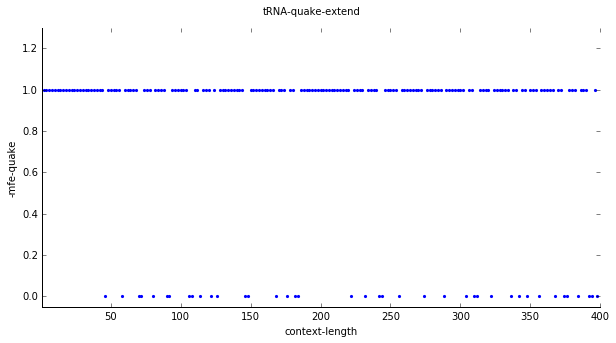

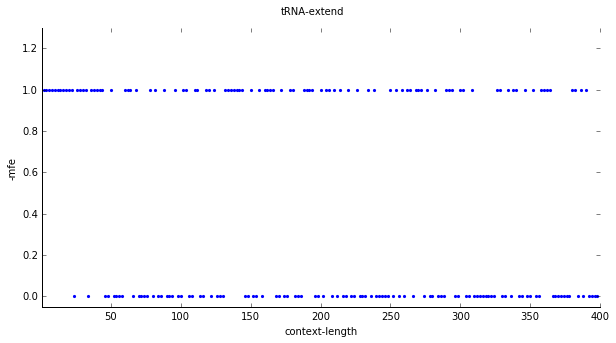

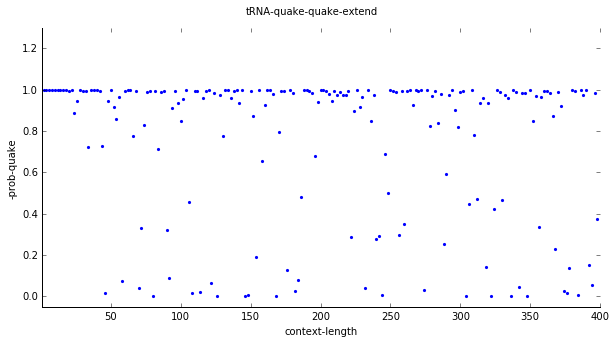

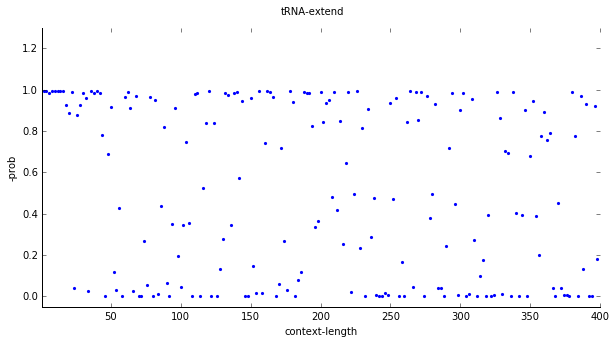

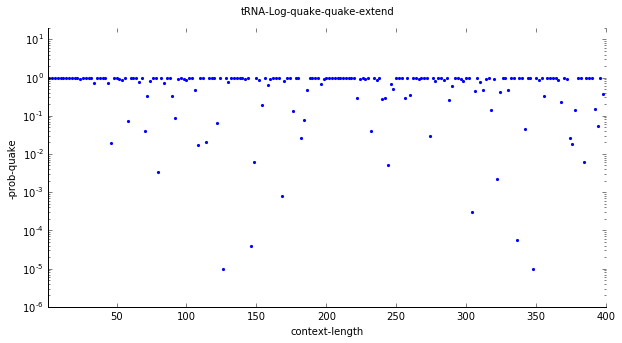

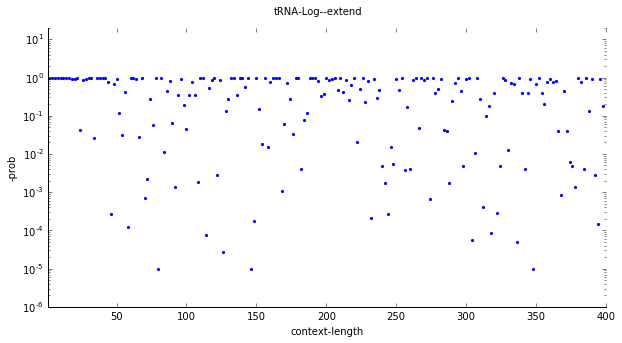

In [142]:
# df_trnaa = my_eval(trna2, context_trna2, 2, 68, 34, 2)
# df_trna_quake = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=True) 
# df_trna = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=False) 
df_trna_both = my_eval(trna2, context_trna2, 3, 67, 34, 2, use_pywrapper=False, quake_opts=[False, True]) 

# stem="CAUUGUAUUUGUAAUGCGGUG"
# stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
# df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)
# plot_scatter_df(df_stemtest, 'stem',what='both')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')
plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=False)


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')
plot_scatter_df(df_trna_both, 'tRNA-quake',what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='extend')

plot_scatter_df(df_trna_both, 'tRNA-Log-quake', scale='log', what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA-Log-', scale='log', what='extend')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

( 0 0 0 ) ( 2 1 1 ) ( 4 2 0 ) ( 6 3 0 ) ( 8 4 6 ) ( 10 5 6 ) ( 12 6 8 ) ( 14 7 6 ) ( 16 8 9 ) ( 18 9 10 ) ( 20 10 11 ) ( 22 11 9 ) ( 24 12 10 ) ( 26 13 11 ) ( 28 14 10 ) ( 30 15 14 ) ( 32 16 17 ) ( 34 17 20 ) ( 36 18 19 ) ( 38 19 21 ) ( 40 20 20 ) ( 42 21 25 ) ( 44 22 19 ) ( 46 23 20 ) ( 48 24 20 ) ( 50 25 32 ) ( 52 26 27 ) ( 54 27 26 ) ( 56 28 32 ) ( 58 29 35 ) ( 60 30 28 ) ( 62 31 41 ) ( 64 32 34 ) ( 66 33 41 ) ( 68 34 32 ) ( 70 35 33 ) ( 72 36 40 ) ( 74 37 30 ) ( 76 38 34 ) ( 78 39 28 ) ( 80 40 40 ) ( 82 41 40 ) ( 84 42 44 ) ( 86 43 46 ) ( 88 44 42 ) ( 90 45 40 ) ( 92 46 42 ) ( 94 47 45 ) ( 96 48 50 ) ( 98 49 49 ) ( 100 50 49 ) ( 102 51 59 ) ( 104 52 50 ) ( 106 53 46 ) ( 108 54 48 ) ( 110 55 52 ) ( 112 56 60 ) ( 114 57 61 ) ( 116 58 55 ) ( 118 59 56 ) ( 120 60 63 ) ( 122 61 70 ) ( 124 62 60 ) ( 126 63 64 ) ( 128 64 68 ) ( 130 65 54 ) ( 132 66 63 ) ( 134 67 70 ) ( 136 68 63 ) ( 138 69 66 ) ( 140 70 64 ) ( 142 71 61 ) ( 144 72 62 ) ( 146 73 74 ) ( 148 74 73 ) ( 150 75 84 ) ( 152 76 70

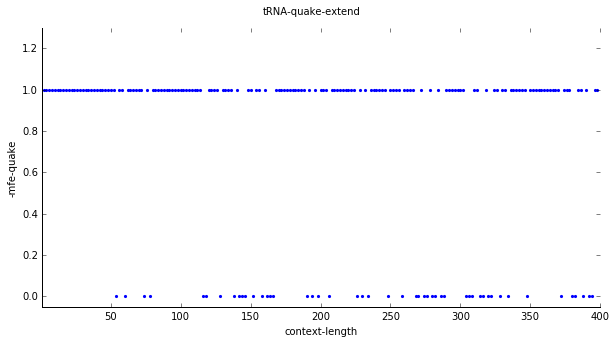

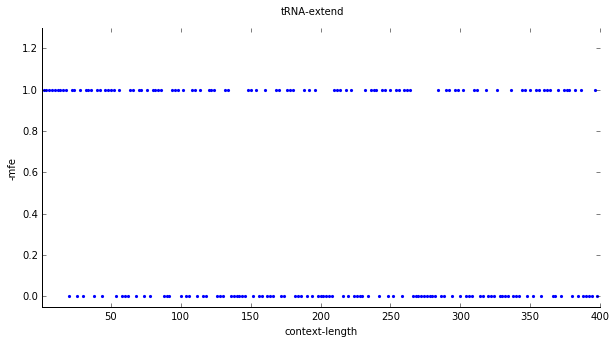

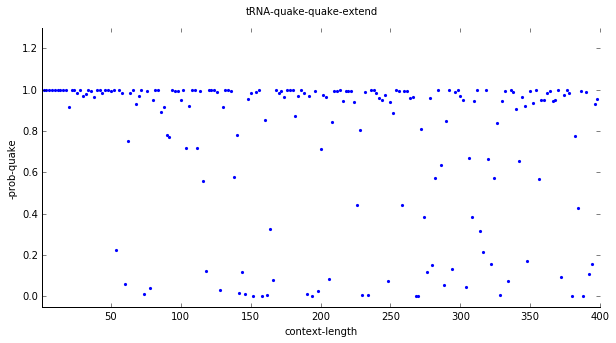

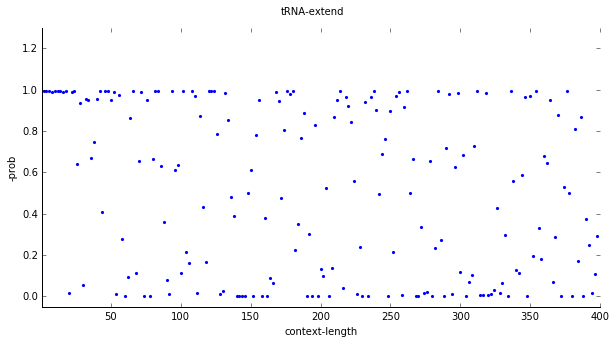

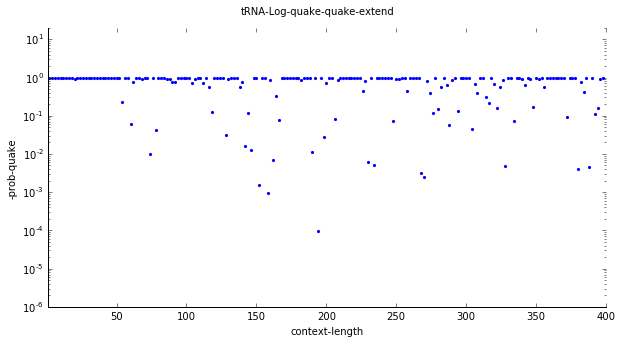

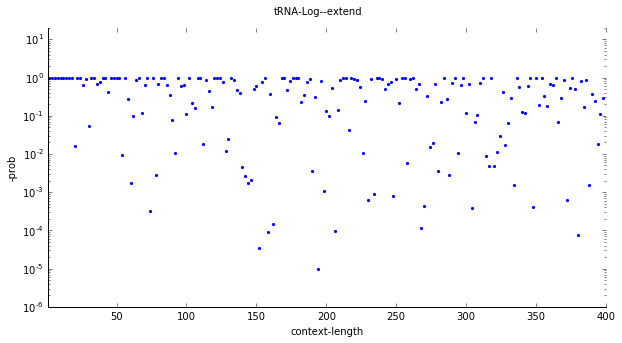

In [137]:
# df_trnaa = my_eval(trna2, context_trna2, 2, 68, 34, 2)
# df_trna_quake = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=True) 
# df_trna = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=False) 
df_trna_both = my_eval(trna2, context_trna2, 3, 67, 34, 2, use_pywrapper=False, quake_opts=[False, True]) 

# stem="CAUUGUAUUUGUAAUGCGGUG"
# stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
# df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)
# plot_scatter_df(df_stemtest, 'stem',what='both')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')
plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=False)


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')
plot_scatter_df(df_trna_both, 'tRNA-quake',what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='extend')

plot_scatter_df(df_trna_both, 'tRNA-Log-quake', scale='log', what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA-Log-', scale='log', what='extend')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

In [140]:
# df_trna_both_lovely = df_trna_both.copy()
df_trna_both_lovely


,context-length,extend-prob,split-prob,extend-mfe,split-mfe,extend-prob-quake,split-prob-quake,extend-mfe-quake,split-mfe-quake
0,0,0.994732,0.994732,1,1,0.997637,0.997637,1,1
1,2,0.994418,0.994734,1,1,0.997635,0.997637,1,1
2,4,0.994684,0.994733,1,1,0.997636,0.997637,1,1
3,6,0.994565,0.994731,1,1,0.997636,0.997636,1,1
4,8,0.990211,0.994706,1,1,0.997588,0.997633,1,1
5,10,0.994857,0.994734,1,1,0.997647,0.997637,1,1
6,12,0.992971,0.994586,1,1,0.997615,0.997617,1,1
7,14,0.994858,0.994721,1,1,0.997647,0.997635,1,1
8,16,0.991256,0.994734,1,1,0.997598,0.997637,1,1
9,18,0.993870,0.994690,1,1,0.997636,0.997631,1,1


In [76]:
import random
random.seed(10)
np.random.seed(100)
E.enable_nbextension('usability/codefolding/main')

# >X57128.1_136-761-context-only
# cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaacuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugccuggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcugcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgcccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac

# >X57128.1_614-639 
# gaaaaggcucuuuucagagccacuca
context_histone = "cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaa\
cuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugcc\
uggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcu\
gcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgc\
ccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac"
histone = "gaaaaggcucuuuucagagccacuca"
trna = "ggcggcauggccaagcgguaaggcaggggacugcaaauccuuuauccccaguucaaaucugggugccgccu";
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"

# print compute_mfe_probability("uauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaa\
# auuGCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCUguaaauccguauuauuuauaaau\
# ugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaau")

# print compute_mfe_probability("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs = getBPPM("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs[np_bp_probs.nonzero()]
 

/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):
/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):


[1, 3]


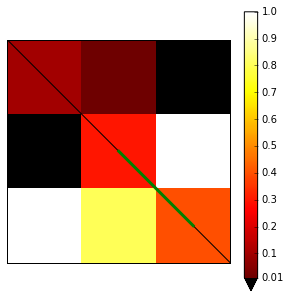

In [46]:
%matplotlib inline
mpld3.enable_notebook()

mynp = np.array([[0.1,0.01,0.001],[0.00,0.3,1.0],[1.0,0.8,.4]])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
# my_heatmap(mynp, fig, ax)
my_heatmap(mynp, fig, ax, inverse=False, interactive=False, gene_loc=[1,3])


UUCGCGCAAAGUUUUAAAGUGAAAAUAAGAUCCCCGAUUUGUUUUGGAUUUUGAUUUGAGUUCAUACCUUUAAUUAGCUUUGAUUUUCAAAUAGAUUAAAGCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCUUAAGUAAAAGUUUAAAGAUUUAGAUAGGUUUUGUAGUUAAUGUCCUUUCA
72 150 100
602
[100, 172]
[100, 172]
[100, 172]
[100, 172]


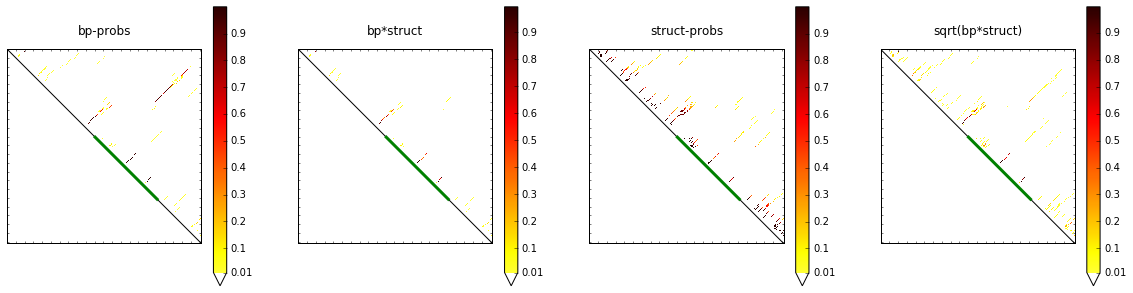

In [102]:
# RNA.get_pr(l_pos+1, r_pos+1)
# context_histone_shuffled = dinuclShuffle(context_histone.upper())
# context_trna2_shuffled = dinuclShuffle(context_trna2.upper())

# my_heatmaps(histone, context_histone_shuffled,context_len = 150, filename='histone-shuffled-150', 
#            what='all')
my_heatmaps(trna2, context_trna2_shuffled, insert_pos=100, context_len=150, filename='trna-shuffled-150',
           what ='all')
# my_heatmaps(trna2, context_trna2_shuffled, context_len=0, filename='trna-shuffled-0')



In [104]:
# >BX571868.1_244896-246219 CONTEXT 500 Rfam RF00040:245396-245719;	sequence=known_nt;	324;	rne5;	RNase E 5' UTR element;	EMBL desc: Photorhabdus luminescens subsp. laumondii TTO1 complete genome; segment 10/17
context_rne5 = "UAUAAGAUACAAUCGUCUAAUGCAGCGACUUUAUCCAGUUUAGCUGAAACUGGCACUGCUUGCCGUUCUGCAACCCGAACCGGUGG\
AAUUCUGACAACAUCCCCCGCAGACAAUUUAUACUCAGGUUUUAUCCUGCCUUUAUUUAUCCGCACUUCCCCCUUACGCACAAUCCGGUAAAUC\
AUGCUCUUAGGAACACCCUUCAAACGCGCUAAUAAAAAAUUAUCAACUCGCUGUCCAGCUUCAUCGUCAUCAAUAGUGACAAAUUGUACAACUU\
GAUUAUUCGUUUUCAUGAUAGCAAUUUUAAUUAUCACUCAAGCAGAGUGCUACUCAUUUUUAAAUAUGUGUAAAAAUCACGCAUACUUUCCGGU\
UGUUACCUUCGCUACUUUAAGAUAAAGAUUAAAUAUUAACUAUUUCUUCCUAUUUCAUCAGAAAAACCGCUUAAAGACAUAAAGUCACCUUGCU\
AUCACCCCAACAGCAAUGGAAUAAUACGUAGCCACCAUCAGUUUUUUAAUCCUGAAUGGCGAAGUUAAACGUUUGUUCUUCAUUUGAUUGCACA\
AAAACGCAGCAAUGGCGUAAGACGUACUGGGAAAUCAAAUAAUUAGCGGGCUACGGGUAGCAGAUUACUGGAAUCGGAUCAAAUCAGCUUCAUU\
UAUAUUUGCAGAUUAUUCCUAGAAAAGGGUACUGUUUUCUAAGUGAAAAUUCAGACCUGCCGAAAAUAUGCGUCUCUAUACAAACGACAACCGG\
GAGGUUGGCGGAUUUGUAAAAGACACGAGACCAUCGGUUACCAGUCGCUCAUCUAUAUUUGCCCGUAGCUCUAUAACUAAUGUAAAAAAUAAUG\
AGUAAGUUACAAUGAAAAGAAUGCUAAUCAACGCAACUCAGCAAGAAGAGUUGCGUGUUGCUCUGGUUGACGGGCAACGCCUUUAUGAUUUGGA\
UAUCGAAAGCCCAGGACACGAGCAGAAAAAAGCAAAUAUCUACAAAGGUAAAAUCACCCGAAUUGAACCUAGUCUGGAAGCUGCUUUUGUUGAC\
UACGGCGCUGAACGGCAUGGUUUCCUUCCUAUUAAAGAAAUAGCCCGCGAAUAUUUUCCCAAUAACUACCAUCCUCACGGUCGCCCUAAUAUCA\
AAGAUGUUUUAAGGGAGGGCCAGGAAGUUAUCGUUCAAGUCGAUAAAGAAGAACGUGGUAAUAAAGGGGCCGCCUUAACCACUUUUAUCAGUCU\
GGCGGGCAGUUAUCUGGUACUCAUGCCCAAUAACCCUCGCGCAGGCGGUAUUUCCCGCCGUAUCGAAGGAGAUGACCGCACAGAACUGAAAGAA\
GCGUUGGCAUCGUUAG"
my_heatmaps(context_rne5, None, insert_pos=200, context_len=500, filename='rne5-500',
           what ='all', motif_len=324)

Full sequence and context given


KeyboardInterrupt: 

In [88]:
shuffle1 = dinuclShuffle(context_trna2.upper())
shuffle2 = dinuclShuffle(context_trna2.upper())
print shuffle1
print
print shuffle2


UGGUUUUUUAAAAUAAUUAAUUGUUUUGGUUUAAGUUUCGUCUUCCAAGGUGUUUUAUCACUAUGAAUCAUAGGAUCCCAGGCUUUCAGUUUUAAAAUUCUCACUUCGCCUUUGAAUUUAAUUGUUUGAUUGUUAAUUCACUUUUAUUCAUUAGCUAUGAUAAUCUUUUUGCAAUUCCAUAAAAAUAUAAAUGCCCCAGUGCCUAAAGUAAGUUUUAUGGGGUUGAGCAUAAUUAAAUUUUCCUACAAUUAAUUUGCUAGUGUAAUUAAUAUAUUAAACAGUAGCUCUUUAAAGGGAAUCCUUAUUAGUUGGAGUUUUUAAAGAAUCAAAGAAAAUGGUUUAGAUGCAAUCCAAAGUUUAAAACAUCGCGUCUGGCAGAUGUUUAUAAGUUUGGAGUUAAAUUUGAUCAAUUUUAGAGGAUUUUAUAUUAGUUUAGUGUUAGUUUUUUUUAGCGUCGUUGGUUUUGUUUUUUCGCAUUAGCAGAAUAUGCUUGAUCAAAUAUAUGUAUUAAAUAAUCGCAAAUCAAUCAUUCAAGUGUGCUUGGUUAUUUCUAUCACAUAGUCAGUUAUUCCUGAAAUAAUUUAUUUAAUUAUUUAUAAG

UUAAUUAUUUAAAAAUUUAUAUUAUUAUUGGAAGGUAUGGUUUUUCAUCUUUUUGAUCAGGUUUAGUUAAAAUGGAACAUUUUGCCUAAUUCCAUAAGUCAGAUAGUUAAAUUAAAUAAUUAGUUAUAAGUUGGGAAUUCCAAUCUUGUUUUGUUGUAGCUAGUUGUCUGCCAUGUCUUAUUUACCUUUUUAGUAUCUCAAGCUUCAUUAUUUGGUUAAAUCUGUUUUUUAUUUCCUCUUUUAUUCAAUAUCUAGUAUAGAGUAAAAUUUAUGCUGUUUUUCGCGCUUGCAAAAAAAGUUAAAUCCAACAUUGUUGAAUUUUAUCGUUUUCAAUUGUUUUGUCAGCAUAGAUAGGGCAUCCACAACCGGUUCAAGAAUAAAAGUAAUGCCAUUGUUAU

In [ ]:
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"
random.seed(1)
np.random.seed(10)

context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2 = context_trna2_shuffled[0:100] + trna2 + context_trna2_shuffled[100:200]
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2_assymetric = context_trna2_shuffled[0:120] + trna2 + context_trna2_shuffled[120:200]

print ">sample_trna2\n", sample_trna2

In [ ]:
context_histone_shuffled = dinuclShuffle(context_histone.upper())
sample_histone = context_histone_shuffled[0:100] + histone + context_histone_shuffled[100:200]
print ">sample_histone\n", sample_histone

In [ ]:
import pickle
with open('targets-pankoff/'+ 'sample_trna_foldscore_dict' + '.pkl', 'rb') as f:
    sample_trna2_loaded_dict = pickle.load(f)

mpld3.disable_notebook()

plot_dp_ps('./targets-pankoff/cluster_10546_dp.ps')

In [ ]:
sample_np = bpp_dict_to_np_array(sample_trna2_loaded_dict, sample_trna2) 
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
my_heatmap(sample_np, fig, ax)
fig.savefig('foldscore_sample_trna2.pdf')

In [ ]:
# plot_heat_maps(get_mfe_probs(sample_trna2), getBPPM(sample_trna2), 'sample_trna2', 'all')
plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs', 'basepairs', inverse=True, interactive=True)
# plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs_inverse', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_asymmetric', 'basepairs', inverse=True)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_inverse_asymmetric', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(trna2), 'X70810.2_heatmap', 'basepairs', inverse=True, interactive=True)

In [ ]:
struct = ""
t = RNA.fold_compound("GCCGAAAGGC")#, struct)
print t.mfe()
t.__class__
# RNA.fold_compound.
# RNA.fold_compound.mfe(t)
# RNA.fold_compound.type()
# print t

import RNA
print RNA.__path__
structure = ""
# print RNA.pf_fold("AAGGGAAACCCAGGCGGCGC", structure)
# VRNA_VC_TYPE_SINGLE
RNA.Lfold("AAGGGAAACCCAGGCGGCGC")